In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants as const
import scipy
from scipy.special import erfc
import pandas as pd

In [2]:
johnson_nyquist_noise = lambda R, T, B: np.sqrt(4 * const.k * T / R * B)
johnson_nyquist_noise_psd = lambda R, T: 4 * const.k * T / R
johnson_nyquist_noise_rms = lambda R, T: np.sqrt(4 * const.k * T / R)

In [3]:
print(f"Johnson Nyquist Noise PSD = {johnson_nyquist_noise_psd(R=3.8e3, T=273+105)*1e24:0.2f} [pA^2/Hz^0.5], Johnson Nyquist Noise RMS {johnson_nyquist_noise_rms(R=3.8e3, T=273+105)*1e12:0.2f} [pA/Hz^0.5], Integrated Johnson Nyquist Noise {johnson_nyquist_noise(R=3.8e3, T=273+105, B=40e9)*1e6:0.2f} [uA]")

Johnson Nyquist Noise PSD = 5.49 [pA^2/Hz^0.5], Johnson Nyquist Noise RMS 2.34 [pA/Hz^0.5], Integrated Johnson Nyquist Noise 0.47 [uA]


In [4]:
tiagaindB20 = pd.read_csv('tiagaindB20.csv')
tiainnoise = pd.read_csv('tiainnoise.csv')
tiaoutnoise = pd.read_csv('tiaoutnoise.csv')

tia_shot_noise = pd.read_csv('shot_noise_out_of_TIA_30uW.csv')
tia_shot_noise.columns = ["f", "noise"]

(0.1, 100)

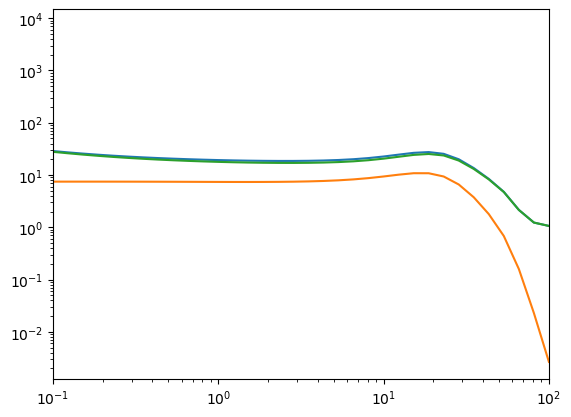

In [5]:
plt.loglog(tiaoutnoise['output noise spectrum X']/1e9, tiaoutnoise['output noise spectrum Y']/1e-9, label='TIA total noise')
plt.loglog(tia_shot_noise['f']/1e9, np.sqrt(tia_shot_noise['noise'])/1e-9, label='TIA shot_noise')
plt.loglog(tiaoutnoise['output noise spectrum X']/1e9, np.sqrt(tiaoutnoise['output noise spectrum Y']**2 - tia_shot_noise['noise'])/1e-9, label='TIA input noise')
plt.xlim([0.1, 100])


In [6]:
location = lambda f: np.argmin(np.abs(tiagaindB20['pnoise gain X'].values - f))

bw_2n = 28e9 * 1.49
freq = bw_2n
freq =30e9
idx_freq = location(freq)

peak_gain_dBohm = np.max(tiagaindB20['pnoise gain Y'])
peak_gain_ohm = 10**(peak_gain_dBohm / 20)
tia_input_referred_noise = np.sqrt(scipy.integrate.trapezoid(tiainnoise['input noise spectrum Y'][0:idx_freq+1].values**2, tiainnoise['input noise spectrum X'][0:idx_freq+1].values))
tia_output_noise = np.sqrt(scipy.integrate.trapezoid(tiaoutnoise['output noise spectrum Y'][0:idx_freq+1].values**2, tiaoutnoise['output noise spectrum X'][0:idx_freq+1].values))
print(f"Peak gain in {peak_gain_ohm:0.2f} Ohm or {peak_gain_dBohm:0.2f} dBOhm, TIA + Post-Amp input referred noise: {tia_input_referred_noise*1e6:0.2f} uA, TIA + Post-Amp output noise: {tia_output_noise*1e3:0.2f} mV")

Peak gain in 3984.01 Ohm or 72.01 dBOhm, TIA + Post-Amp input referred noise: 2.33 uA, TIA + Post-Amp output noise: 4.03 mV


Text(0.5, 1.0, 'TIA + Post-Amp Gain and Noise integrated to 30 [GHz]')

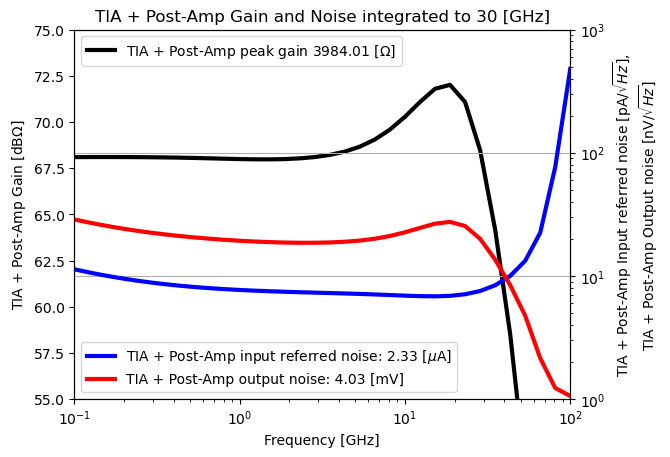

In [7]:
fig, ax1 = plt.subplots()
ax1.semilogx(tiagaindB20['pnoise gain X']/1e9, tiagaindB20['pnoise gain Y'], linewidth=3.0,color='k', label=f'TIA + Post-Amp peak gain {peak_gain_ohm:0.2f}'+r' [$\Omega$]')
ax2 = ax1.twinx()
ax2.loglog(tiainnoise['input noise spectrum X']/1e9, tiainnoise['input noise spectrum Y']/1e-12,linewidth=3.0,color='b', label=f'TIA + Post-Amp input referred noise: {tia_input_referred_noise*1e6:0.2f}'+r' [$\mu$A]')
ax2.loglog(tiaoutnoise['output noise spectrum X']/1e9, tiaoutnoise['output noise spectrum Y']/1e-9,linewidth=3.0, color='r', label=f"TIA + Post-Amp output noise: {tia_output_noise*1e3:0.2f} [mV]")
ax1.legend(loc='upper left')
ax2.legend(loc='lower left')
ax1.set_xlabel('Frequency [GHz]')
ax1.set_ylabel(r'TIA + Post-Amp Gain [dB$\Omega$]')
ax2.set_ylabel(r'TIA + Post-Amp Input referred noise [pA/$\sqrt{Hz}$],'+'\n'+r'TIA + Post-Amp Output noise [nV/$\sqrt{Hz}$]')
ax1.set_xlim([0.1, 100])
ax1.set_ylim([55, 75])
ax2.set_ylim([1, 1e3])
ax2.grid(True)
plt.title(f'TIA + Post-Amp Gain and Noise integrated to {freq/1e9:0.0f} [GHz]')


Text(0, 0.5, 'TIA Input Referred Noise [pA/$\\sqrt{Hz}$]')

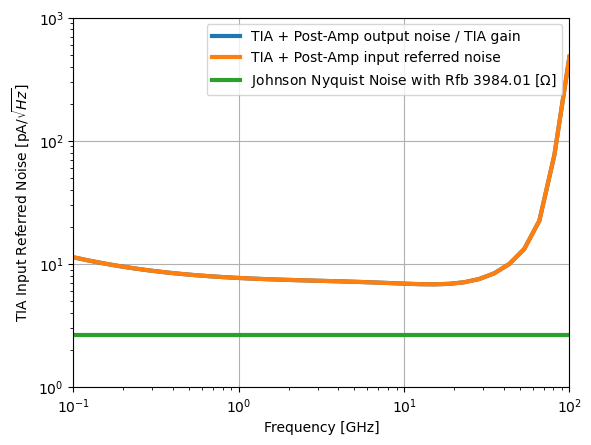

In [8]:
plt.loglog(tiaoutnoise['output noise spectrum X']/1e9,tiaoutnoise['output noise spectrum Y']/1e-12/10**(tiagaindB20['pnoise gain Y']/20), linewidth=3.0, label='TIA + Post-Amp output noise / TIA gain')
plt.loglog(tiainnoise['input noise spectrum X']/1e9, tiainnoise['input noise spectrum Y']/1e-12, linewidth=3.0, label='TIA + Post-Amp input referred noise')
plt.loglog(tiaoutnoise['output noise spectrum X']/1e9, np.ones(len(tiaoutnoise['output noise spectrum X']))*johnson_nyquist_noise_rms(R=3e3, T=273+105)*1e12, linewidth=3.0, label='Johnson Nyquist Noise with Rfb 'f'{peak_gain_ohm:0.2f}'+r' [$\Omega$]')
plt.grid(True)
plt.xlim([0.1, 100])
plt.ylim([1e0, 1e3])
plt.legend()
plt.xlabel('Frequency [GHz]')
plt.ylabel(r'TIA Input Referred Noise [pA/$\sqrt{Hz}$]')

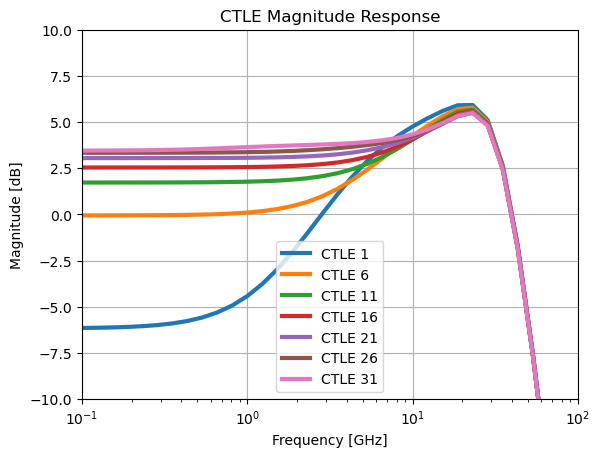

In [9]:
skipper_ctle = pd.read_excel('Skipper-CTLE-Hs-coefficents.xlsx', header=4)
fmax = 1e11
f_range = np.linspace(0, fmax, 1000)
f_range = tiagaindB20['pnoise gain X'].values
w = 2 * np.pi * f_range * 1j
ctle = skipper_ctle['degen1'].values
for idx_ctle in ctle:
  row_idx_ctle = skipper_ctle.iloc[idx_ctle-1]
  b_array = np.array([row_idx_ctle['b(1)'], row_idx_ctle['b(2)'],row_idx_ctle['b(3)'],row_idx_ctle['b(4)']])
  a_array = np.array([row_idx_ctle['a(1)'], row_idx_ctle['a(2)'],row_idx_ctle['a(3)'],row_idx_ctle['a(4)'],
             row_idx_ctle['a(5)'], row_idx_ctle['a(6)'],row_idx_ctle['a(7)'],row_idx_ctle['a(8)']])
  H = np.polyval(b_array, w) / np.polyval(a_array, w)
  Hmag = 20*np.log10(np.abs(H))
  txt = f'CTLE {idx_ctle:0.0f}'
  if idx_ctle%5 == 1:
    plt.semilogx(f_range/1e9, Hmag, linewidth=3.0, label=txt)
plt.xlim([0.1,100])
plt.ylim([-10,10])
plt.xlabel('Frequency [GHz]')
plt.ylabel('Magnitude [dB]')
plt.title('CTLE Magnitude Response')
plt.grid(True)
plt.legend()
plt.show()

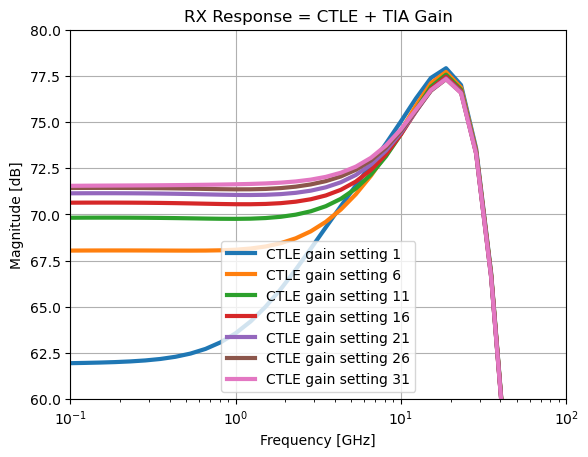

In [10]:
fmax = 1e11
f_range = np.linspace(0, fmax, 1000)
f_range = tiagaindB20['pnoise gain X'].values
w = 2 * np.pi * f_range * 1j
ctle = skipper_ctle['degen1'].values
for idx_ctle in ctle:
  row_idx_ctle = skipper_ctle.iloc[idx_ctle-1]
  b_array = np.array([row_idx_ctle['b(1)'], row_idx_ctle['b(2)'],row_idx_ctle['b(3)'],row_idx_ctle['b(4)']])
  a_array = np.array([row_idx_ctle['a(1)'], row_idx_ctle['a(2)'],row_idx_ctle['a(3)'],row_idx_ctle['a(4)'],
             row_idx_ctle['a(5)'], row_idx_ctle['a(6)'],row_idx_ctle['a(7)'],row_idx_ctle['a(8)']])
  H = np.polyval(b_array, w) / np.polyval(a_array, w)
  Hmag = 20*np.log10(np.abs(H))
  txt = f'CTLE gain setting {idx_ctle:0.0f}'
  if idx_ctle%5 == 1:
    plt.semilogx(f_range/1e9, Hmag + tiagaindB20['pnoise gain Y'], linewidth=3.0, label=txt)
plt.xlim([0.1,100])
plt.ylim([60,80])
plt.xlabel('Frequency [GHz]')
plt.ylabel('Magnitude [dB]')
plt.title('RX Response = CTLE + TIA Gain')
plt.grid(True)
plt.legend()
plt.show()

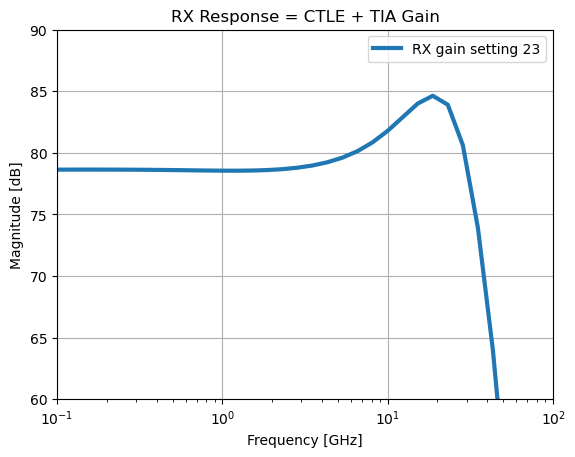

In [11]:
def ctle_tia_gain(idx_ctle):
  f_range = tiagaindB20['pnoise gain X'].values
  w = 2 * np.pi * f_range * 1j
  row_idx_ctle = skipper_ctle.iloc[idx_ctle]
  b_array = np.array([row_idx_ctle['b(1)'], row_idx_ctle['b(2)'],row_idx_ctle['b(3)'],row_idx_ctle['b(4)']])
  a_array = np.array([row_idx_ctle['a(1)'], row_idx_ctle['a(2)'],row_idx_ctle['a(3)'],row_idx_ctle['a(4)'],
            row_idx_ctle['a(5)'], row_idx_ctle['a(6)'],row_idx_ctle['a(7)'],row_idx_ctle['a(8)']])
  H = np.polyval(b_array, w) / np.polyval(a_array, w)
  Hmag = 20*np.log10(np.abs(H))
  return Hmag + tiagaindB20['pnoise gain Y']

rx_gain = ctle_tia_gain(23) + 7.3
plt.semilogx(f_range/1e9, rx_gain, linewidth=3.0, label='RX gain setting 23')
plt.xlim([0.1,100])
plt.ylim([60,90])
plt.xlabel('Frequency [GHz]')
plt.ylabel('Magnitude [dB]')
plt.title('RX Response = CTLE + TIA Gain')
plt.grid(True)
plt.legend()
plt.show()

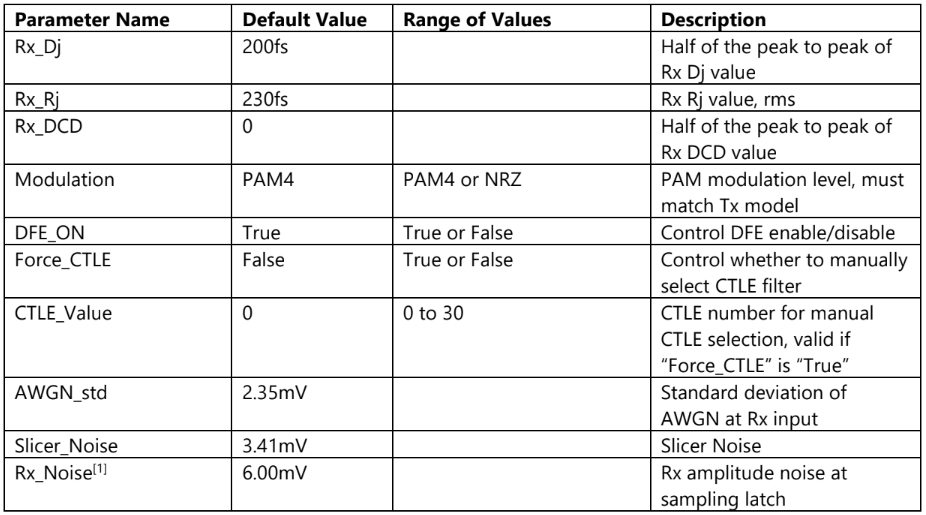

In [12]:
ctle_vn_rms = 2.235e-3
slicer_vn_rms = 3.41e-3 

bw_2n = 28e9 *1.5

ctle_vn_psd = np.sqrt(ctle_vn_rms**2 / bw_2n) * np.ones(len(f_range))
slicer_vn_psd = np.sqrt(slicer_vn_rms**2 / bw_2n) * np.ones(len(f_range))

print(f"CTLE voltage-noise PSD: {ctle_vn_psd[0]*1e9:0.2f} [nV/sq(Hz)], Slicer voltage-noise PSD: {slicer_vn_psd[0]*1e9:0.2f} [nV/sq(Hz)]")

CTLE voltage-noise PSD: 10.91 [nV/sq(Hz)], Slicer voltage-noise PSD: 16.64 [nV/sq(Hz)]


In [13]:
input_referred_ctle_noise_psd = ctle_vn_psd / 10**(tiagaindB20['pnoise gain Y']/20)
input_referred_slicer_noise_psd = slicer_vn_psd / 10**(rx_gain/20)
total_input_referred_noise_psd = np.sqrt(tiainnoise['input noise spectrum Y']**2 + input_referred_ctle_noise_psd**2 + input_referred_slicer_noise_psd**2)

In [14]:
total_tia_input_referred_noise = np.sqrt(scipy.integrate.trapezoid(total_input_referred_noise_psd[0:idx_freq+1]**2, f_range[0:idx_freq+1]))
print(f"Total TIA input referred noise: {total_tia_input_referred_noise*1e6:0.2f} uA")

Total TIA input referred noise: 2.41 uA


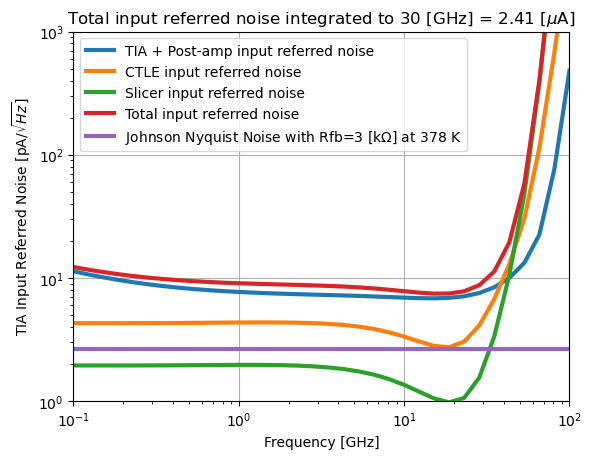

In [15]:
plt.loglog(tiainnoise['input noise spectrum X']/1e9, tiainnoise['input noise spectrum Y']/1e-12, linewidth=3.0, label='TIA + Post-amp input referred noise')
plt.loglog(f_range/1e9, input_referred_ctle_noise_psd/1e-12, linewidth=3.0, label='CTLE input referred noise')
plt.loglog(f_range/1e9, input_referred_slicer_noise_psd/1e-12, linewidth=3.0, label='Slicer input referred noise')
plt.loglog(tiainnoise['input noise spectrum X']/1e9, total_input_referred_noise_psd/1e-12, linewidth=3.0, label='Total input referred noise')
plt.loglog(tiaoutnoise['output noise spectrum X']/1e9, np.ones(len(tiaoutnoise['output noise spectrum X']))*johnson_nyquist_noise_rms(R=3e3, T=273+105)*1e12, linewidth=3.0, label='Johnson Nyquist Noise with Rfb=3'+r' [k$\Omega$] at 378 K')
plt.grid(True)
plt.xlim([0.1, 100])
plt.ylim([1e0, 1e3])
plt.legend()
plt.xlabel('Frequency [GHz]')
plt.ylabel(r'TIA Input Referred Noise [pA/$\sqrt{Hz}$]')
plt.title(f'Total input referred noise integrated to {freq/1e9:0.0f} [GHz] = {total_tia_input_referred_noise*1e6:0.2f}'+r' [$\mu$A]')
plt.show()